# Getting and pre-processing S-PLUS data

This notebook gets and pre-process S-PLUS data. The steps follow as:

   1) Getting `fz` data from S-PLUS;
   2) Converting `fz` to `fits`;
   3) Converting `fits` to RGB image;
   4) Cropping the borders;
   5) Converting original S-PLUS mask to image/matrix form;
   6) Saving the saturated positions from original mask;

## Libraries

In [1]:
import os
import getpass
import splusdata
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import make_lupton_rgb
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import scipy.ndimage

## 1) Getting `fz` data from S-PLUS

### User inputs

Here you select the field that you will be working with

In [2]:
field = 'STRIPE82-0113'#'HYDRA-0167'

Creating directories to save the results

In [3]:
ddirectory = 'data/'+field+'/'
rdirectory = 'results/'+field+'/fits/'
if not os.path.exists(ddirectory):
    os.makedirs(ddirectory)
if not os.path.exists(rdirectory):
    os.makedirs(rdirectory)

Login to S-PLUS

In [4]:
print("Getting connection with S-PLUS")
username = input(prompt="Login: ")
password = getpass.getpass("Password: ")
conn = splusdata.connect(username, password)

Getting connection with S-PLUS


Login:  natalidesanti
Password:  ········


Getting the `fz`s

In [5]:
hdu_R = conn.get_field(field, 'R')
hdu_G = conn.get_field(field, 'G')
hdu_I = conn.get_field(field, 'I')

## 2) Converting `fz` to `fits`

### Transforming and saving data

Converting from `fz` to `fits`

In [6]:
def python_fz2fits(image, field, band):
    data = image[1].data
    header = image[1].header
    imageout = 'data/'+field+'/'+field+'_'+band+'.fits'
    fits.writeto(imageout, data, header, overwrite = True)

In [7]:
#Saving the data
R = python_fz2fits(hdu_R, field, 'R')
G = python_fz2fits(hdu_G, field, 'G')
I = python_fz2fits(hdu_I, field, 'I')

In [8]:
del R, G, I, username, password, conn, hdu_R, hdu_G, hdu_I, python_fz2fits

## 3) Converting `fits` to RGB image

Getting the fits to work with

In [9]:
#Getting the fits again
Rimage_file = get_pkg_data_filename('data/'+field+'/'+field+'_R.fits')
Gimage_file = get_pkg_data_filename('data/'+field+'/'+field+'_G.fits')
Iimage_file = get_pkg_data_filename('data/'+field+'/'+field+'_I.fits')

In [10]:
#Get data from fits
Rimage_data = fits.getdata(Rimage_file, ext=0)
Gimage_data = fits.getdata(Gimage_file, ext=0)
Iimage_data = fits.getdata(Iimage_file, ext=0)

Transforming the fits data into RGB images, using [Lupton](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract) algorithm:

In [11]:
rgb_default = make_lupton_rgb(Rimage_data, Gimage_data, Iimage_data, Q = 10, stretch = 0.5)

In [12]:
#Saving the image as a numpy matrix
np.savez('results/'+field+'/RGB_'+field+'.npz', img = rgb_default)

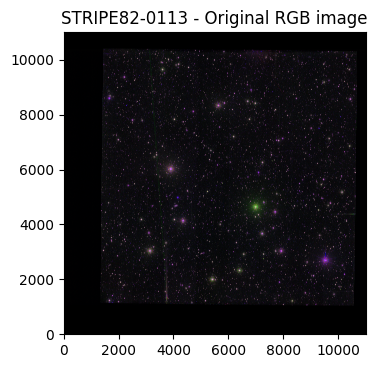

In [13]:
#Visualizing
plt.figure(dpi = 100)
plt.title(field+' - Original RGB image')
plt.imshow(rgb_default, origin = 'lower')
plt.savefig('results/'+field+'/original_RGB_image.png', bbox_inches='tight')

In [14]:
del Gimage_file, Iimage_file, Gimage_data, Iimage_data

## 4) Cropping the borders

Taking only the image, without the black borders

In [15]:
def crop(image):
    size = rgb_default[:, :, 0].shape
    aux = np.where(rgb_default[:, :, 0] > 30)#10)
    min_0 = np.min(aux[0])
    max_0 = np.max(aux[0])
    min_1 = np.min(aux[1])
    max_1 = np.max(aux[1])
    new_image = image[np.min(aux[0]):np.max(aux[0]), np.min(aux[1]):np.max(aux[1])]
    new_size = new_image.shape
    center_0 = (new_size[0]/2) + min_0
    center_1 = (new_size[1]/2) + min_1
    return size, min_0, max_0, min_1, max_1, new_image, new_size, center_0, center_1

In [16]:
size, min_0, max_0, min_1, max_1, cropped, size_c, c0, c1 = crop(rgb_default)

Saving crop information to use later

In [17]:
info_data = np.array([[size[0]], [size[1]], [min_0], [max_0], [min_1], [max_1], [size_c[0]], [size_c[1]], [c0], [c1]]).T
info_columns = ['size[0]', 'size[1]', 'min_0', 'max_0', 'min_1', 'max_1', 'size_c[0]', 'size_c[1]', 'c0', 'c1']
info_df = pd.DataFrame(data = info_data, columns = info_columns)
info_df.to_csv('results/'+field+'/crop_RGB_info.csv', index = False)

In [18]:
#Saving the cropped image as matrix
np.savez('results/'+field+'/crop_RGB_'+field+'.npz', img = cropped)

In [19]:
del crop

### Padding the cropped image

This step is made just to ensure that I have cropped the image properly

In [20]:
color = [0, 0, 0]
top = min_0
bottom = size[0] - max_0
left = min_1
right = size[1] - max_1

In [21]:
img_with_border = cv2.copyMakeBorder(cropped, top, bottom, left, right, cv2.BORDER_CONSTANT, value = color)

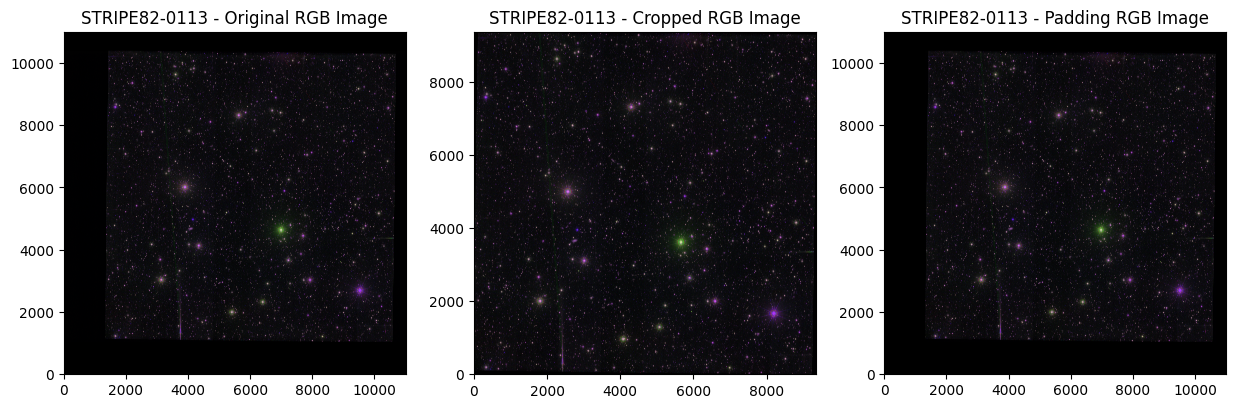

In [22]:
#Visualizing
plt.figure(dpi = 100, figsize = (15, 5))
plt.subplot(1,3,1)
plt.imshow(rgb_default, origin = 'lower')
plt.title(field+' - Original RGB Image')
plt.subplot(1,3,2)
plt.imshow(cropped, origin = 'lower')
plt.title(field+' - Cropped RGB Image')
plt.subplot(1,3,3)
plt.imshow(img_with_border, origin = 'lower')
plt.title(field+' - Padding RGB Image')
plt.savefig('results/'+field+'/comparison-original_cropped_padding.png', bbox_inches='tight')

In [23]:
del img_with_border

## 5) Converting original S-PLUS mask to image/matrix form

### Getting S-PLUS original mask

In order to get a low number of objects to work with and to have the exact position of the bright stars, I get the existing mask for S-PLUS. This mask comprehends the bright/saturated stars and the unreliable objects nearby them, which here I call them by `insiders`. Those masks are tabular data containing the `ID`, `RA`, `Dec` and the `BrightstarFlag`, which indicates if the object is the bright/saturated star (2), or if it is a reliable (0) or not reliable object (1).

In [24]:
#Original mask
bright = pd.read_csv('data/'+field+'/'+'BrightstarFlag_'+field+'.csv')

In [25]:
saturated = bright
saturated = saturated[saturated['BrightstarFlag'] == 2]

In [26]:
inside = bright
inside = inside[inside['BrightstarFlag'] == 1]

### Converting the original mask to pixel coordinates

Here I convert the ICRS sky position (`RA` and `Dec`) to pixel coordinates

In [27]:
f = fits.open(Rimage_file)

In [28]:
w = WCS(f[0].header)

In [29]:
#Saturated objects
c_s = {}
for i in range(saturated.shape[0]):
    c_s[i] = SkyCoord(ra = saturated['RA'].values[i]*u.degree, dec = saturated['Dec'].values[i]*u.degree)

In [30]:
#Inside objects
c_i = {}
for i in range(inside.shape[0]):
    c_i[i] = SkyCoord(ra = inside['RA'].values[i]*u.degree, dec = inside['Dec'].values[i]*u.degree)

In [31]:
positions_s = np.zeros((saturated.shape[0], 2))
for i in range(saturated.shape[0]):
    positions_s[i] = w.world_to_pixel(c_s[i])

In [32]:
positions_i = np.zeros((inside.shape[0], 2))
for i in range(inside.shape[0]):
    positions_i[i] = w.world_to_pixel(c_i[i])

In [33]:
#Saving the saturated objects
d = np.array([positions_s[:, 0], positions_s[:, 1]]).T
columns = ['x', 'y']
df = pd.DataFrame(data = d, columns = columns)
df.to_csv('results/'+field+'/saturated-'+field+'.csv', index = False)

In [34]:
#Saving the inside objects
d = np.array([positions_i[:, 0], positions_i[:, 1]]).T
columns = ['x', 'y']
df = pd.DataFrame(data = d, columns = columns)
df.to_csv('results/'+field+'/inside-'+field+'.csv', index = False)

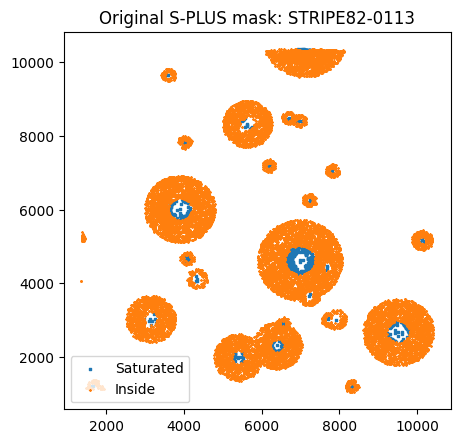

In [35]:
#Visualizing the saturated objects and its insiders
plt.figure(dpi = 100, figsize = (5, 5))
plt.scatter(positions_s[:, 0], positions_s[:, 1], marker = 's', s = 1, label = 'Saturated')
plt.scatter(positions_i[:, 0], positions_i[:, 1], marker = '*', s = 1, label = 'Inside')
plt.legend()
plt.title('Original S-PLUS mask: '+field)
plt.savefig('results/'+field+'/original_mask-objects_positions.png', bbox_inches='tight')

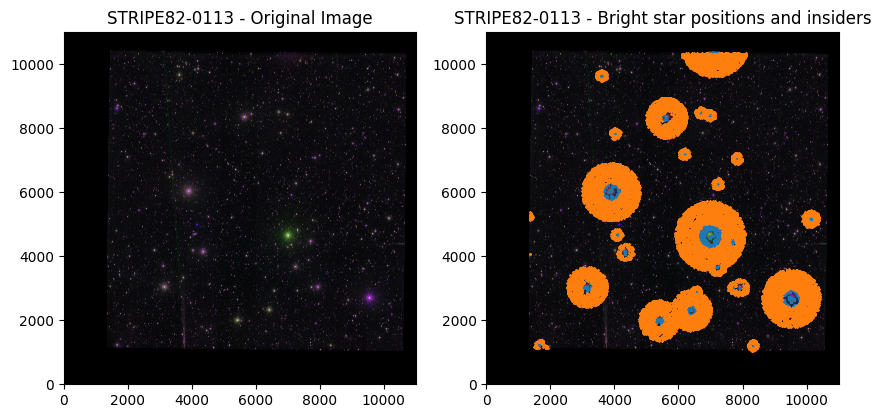

In [36]:
plt.figure(dpi = 100, figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(rgb_default, origin='lower')
plt.title(field+' - Original Image')
plt.subplot(1,2,2)
plt.imshow(rgb_default, origin='lower')
plt.scatter(positions_s[:, 0], positions_s[:, 1], marker = 's', s = 1, label = 'Saturated')
plt.scatter(positions_i[:, 0], positions_i[:, 1], marker = '*', s = 1, label = 'Inside')
plt.title(field+' - Bright star positions and insiders')
plt.savefig('results/'+field+'/comparison-original_mask-objects_positions.png', bbox_inches='tight')

In [37]:
del f, w, c_s, c_i, d, columns, df, bright, inside, saturated

### Converting the mask to a matrix of the size of the cropped image

The original mask comes in a tabular data. Here I convert the tabular data into 'image data' of zeros and ones, of the size of the cropped image. I do this following the steps:
- getting the object positions;
- putting the objects into a box (with a 2 D histogram);
- enlarging the matrix (to the cropped image's size);
- finding the circles, using computer vision technique;
- converting the labels to zeros and ones.

In [38]:
xp = positions_s[:, 0]
yp = positions_s[:, 1]

In [39]:
res_x = np.append(xp, positions_i[:, 0], axis = 0)
res_y = np.append(yp, positions_i[:, 1], axis = 0)

In [40]:
#Getting the pixel object positions into a matrix/or a grid
mask = np.histogram2d(res_y, res_x, bins = 190)[0]

In [41]:
#Enlarging the matrix to the shape of the cropped image
mask_res = cv2.resize(mask, dsize=(cropped.shape[1], cropped.shape[0]), interpolation=cv2.INTER_CUBIC)

The method `label` finds all the objects in some image. Any non-zero values in figure are counted as features and zero values are considered the background. It seems to work perfectly for these astronomical images. This is the main function, from **computer vision** used in this project to find the objects. Here, it works like a _clustering algorithm_.

In [42]:
#It different object receives a label/value
labels, numobjects = scipy.ndimage.label(mask_res)

In [43]:
#Changing all nonzero values to one, to build the mask
original_mask = np.copy(labels)
original_mask[np.where(original_mask > 0)] = 1

In [44]:
#Saving the stripe as matrix
np.savez('results/'+field+'/original_mask-RGB_'+field+'.npz', mask = original_mask)

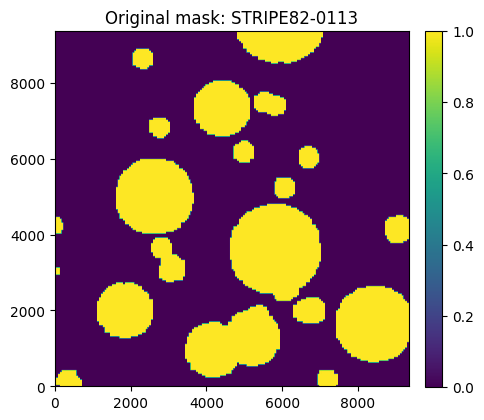

In [45]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.imshow(original_mask, origin='lower')
plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('Original mask: '+field)
plt.savefig('results/'+field+'/original_mask-as_image.png', bbox_inches='tight')

## 6) Saving the saturated positions from original mask

### Geting the saturated objects positions in the cropped image

To use later, in order to select just the bright objects in finding the objects section

In [46]:
new_pos_s = np.copy(positions_s)
new_pos_s[:, 0] = new_pos_s[:, 0] - left
new_pos_s[:, 1] = new_pos_s[:, 1] - top

In [47]:
#Saving the saturated objects
d = np.array([new_pos_s[:, 0], new_pos_s[:, 1]]).T
columns = ['x', 'y']
df = pd.DataFrame(data = d, columns = columns)
df.to_csv('results/'+field+'/cut_saturated-'+field+'.csv', index = False)

In [48]:
del d, columns, df, new_pos_s, cropped, original_mask, labels
del numobjects, mask_res, mask, xp, yp

In [49]:
del positions_s, res_x, res_y